## Track Statistics (Slope, Starting coordinate, Ending coordinate)

#### This program compares the 3 approaches taken to compute the slope of a track in a P8 spectrogram.

In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from scipy import misc
import imageio
from sklearn.metrics import auc
from sklearn import metrics
import math
import random
from scipy import stats
import sklearn
from sklearn.metrics import accuracy_score

In [25]:
pi=math.pi
tan=math.tan
cos=math.cos
sin=math.sin
exp=math.exp
sqrt=math.sqrt

In [4]:
image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
freq_min=10
freq_max=image.shape[1]
t_min=10
t_max=image.shape[0]
mean_life=15

---------------Slope statistics when considering endpoint coordinates-----------


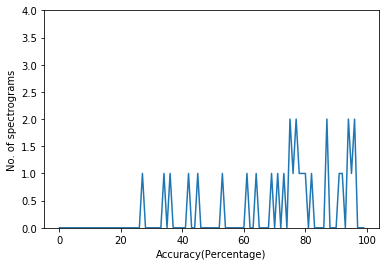

---------------Slope statistics when considering pixels along the track-----------


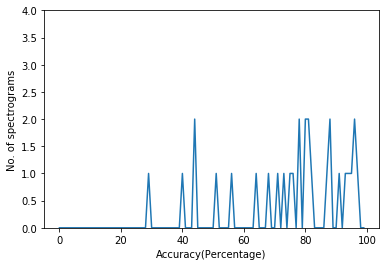

---------------Slope statistics when considering 1D Hough Space---------------


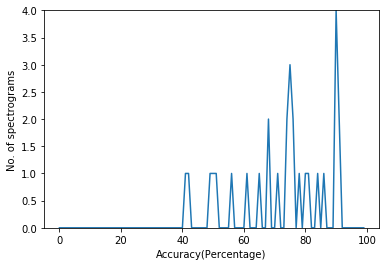

----------------Comparison of all 3 techniques--------------------


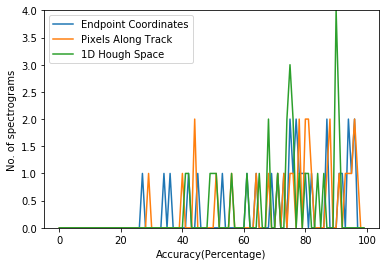

Total time taken: 48.18706655502319


In [62]:
fig=30
accuracy_hist=[]
start=time.time()
slope_stats_mtd1=np.zeros(100)
slope_stats_mtd2=np.zeros(100)
slope_stats_mtd3=np.zeros(100)
for N in range(fig):

    pixel_threshold=5
    angle_dim=8
    window_size=10
    n_std=2.1
    th_consecutive=3
    max_spacing=25
    
    w0=random.randint(freq_min,15)
    t0=random.randint(t_min,15)
    
    alpha=random.uniform(0.775,1.39626)
    #print("Actual angle:",90-np.degrees(alpha))
    SNR=2.5
    sigma=0.5

    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)
    pixel_gray=get_gray(pixel)
    th_true=np.mean(pixel)+np.std(pixel)
    binary_gray=get_binary_gray(pixel_gray,th_true)
    img=get_pixel_new(pixel_gray)

    #end = time.time()
    #print(end-start, "seconds")
    
    #print("------------------After taking consecutive pixels------------------")
    #plt.figure(figsize=(11,11))
    #plt.subplot(131), plt.imshow(img,origin='lower'),plt.title('Noisy Image')
    binary_img, binary_final,slope_avg_mtd3 = local_hough_track_reconstruction_mtd3(img, window_size, angle_dim, pixel_threshold, n_std,th_consecutive,max_spacing)

    #plt.subplot(132),plt.imshow(binary_img,origin='lower'),plt.title('Noisy Binary Image')
    #plt.subplot(133),plt.imshow(binary_final,origin='lower'),plt.title('Reverse Local Hough Tranformation')
    #plt.show()
    
    start_x,start_y,end_x,end_y,slope_avg_mtd1=get_track_stats_mtd1(binary_final,window_size)
    slope_avg_mtd2=get_track_stats_mtd2(binary_final,window_size)
    
    if(np.mean(slope_avg_mtd1)>0 and np.mean(slope_avg_mtd2)>0 and np.mean(slope_avg_mtd3)>0):
        slope_stats_mtd1[int((100-((abs(np.mean(slope_avg_mtd1)-alpha)/alpha))))]=slope_stats_mtd1[int((100-((abs(np.mean(slope_avg_mtd1)-alpha)/alpha))))]+1
        slope_stats_mtd2[int((100-((abs(np.mean(slope_avg_mtd2)-alpha)/alpha))))]=slope_stats_mtd2[int((100-((abs(np.mean(slope_avg_mtd2)-alpha)/alpha))))]+1
        slope_stats_mtd3[int((100-((abs(np.mean(slope_avg_mtd3)-alpha)/alpha))))]=slope_stats_mtd3[int((100-((abs(np.mean(slope_avg_mtd3)-alpha)/alpha))))]+1
    
    #print("No. of track(s) found:",len(start_x))
    #for track in range(len(start_x)):
        #print("--------------Stats for track",track+1,"--------------")
        #print("Start x coord:",start_y[track])
        #print("Start y coord:",start_x[track])
        #print("End x coord:",end_y[track])
        #print("End y coord:",end_x[track])
        #print("Slope from only considering endpoints:",slope_avg_mtd1[track])
        #print("Slope from considering pixels along the track",slope_avg_mtd2[track])
        #print("Slope from 1D Hough Space",slope_avg_mtd3[track])
    
print("---------------Slope statistics when considering endpoint coordinates-----------")    
plt.plot(slope_stats_mtd1)
plt.ylim(0,4,1)
plt.xlabel("Accuracy(Percentage)")
plt.ylabel("No. of spectrograms")
plt.show()

print("---------------Slope statistics when considering pixels along the track-----------")    
plt.plot(slope_stats_mtd2)
plt.ylim(0,4,1)
plt.xlabel("Accuracy(Percentage)")
plt.ylabel("No. of spectrograms")
plt.show()

print("---------------Slope statistics when considering 1D Hough Space---------------")    
plt.plot(slope_stats_mtd3)
plt.ylim(0,4,1)
plt.xlabel("Accuracy(Percentage)")
plt.ylabel("No. of spectrograms")
plt.show()

print("----------------Comparison of all 3 techniques--------------------")
plt.plot(slope_stats_mtd1,label="Endpoint Coordinates")
plt.plot(slope_stats_mtd2,label="Pixels Along Track")
plt.plot(slope_stats_mtd3,label="1D Hough Space")
plt.ylim(0,4,1)
plt.xlabel("Accuracy(Percentage)")
plt.ylabel("No. of spectrograms")
plt.legend(loc='upper left')
plt.show()

end=time.time()
print("Total time taken:",(end-start))
    
    
    #print("------------------No consecutive pixels taken------------------")
    #plt.figure(figsize=(11,11))
    #plt.subplot(131), plt.imshow(img,origin='lower'),plt.title('Noisy Image')
    #binary_img, binary_final = local_hough_track_reconstruction_without(img, window_size, angle_dim, pixel_threshold, n_std)
    #plt.subplot(132),plt.imshow(binary_img,origin='lower'),plt.title('Noisy Binary Image')
    #plt.subplot(133),plt.imshow(binary_final,origin='lower'),plt.title('Reverse Local Hough Tranformation')
    #plt.show()
    
   # accuracy=get_accuracy(binary_gray,binary_final)
   # accuracy_hist.append(accuracy)

#get_accuracy_hist(accuracy_hist,fig)

In [5]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    
    while(True):
        scatter_time=math.floor(t_prev+np.random.exponential(mean_life))  #Scattering times follow an exponential distribution
       # scatter_time=random.randint(t_prev+mean_life,t_prev+3*mean_life) 
        scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
        if((scatter_time>=t_max)or(scatter_freq>=freq_max)):
            break
            
        ybar=freq_prev
        xbar=t_prev
    
        for i in range(t_prev,scatter_time):
            for j in range(freq_prev,scatter_freq):
                intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
                image[j,i]=(intensity,intensity,0)
                
        t_prev=scatter_time+5
        freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    #print("Time:get_image()",end-start)
    return image

In [6]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [7]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
   # print("Time:get_gray()",end-start)
    return pixel_gray

In [8]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
   # print("Time:get_binary_gray",end-start)
    return binary_gray

In [9]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
   # print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [10]:
def get_voting(img, xx, yy, window, angles):
    
    #plt.imshow(window)
    #plt.show()
    
    #m_x=ma.masked_array(xx, mask=np.invert(window))
    #m_y=ma.masked_array(yy, mask=np.invert(window))
    
    #result=m_x*np.cos(angles[:,None,None])+m_y*np.sin(angles[:,None,None])
    result=xx*np.cos(angles[:,None,None])+yy*np.sin(angles[:,None,None])

    voting_matrix = np.zeros(shape=result.shape, dtype=bool)
    
    #bool_mask = (~result.mask)&(np.abs(result)<0.5)
    bool_mask = window[None,:,:]&(np.abs(result)<0.5)
    #bool_mask = np.abs(result)<0.5

    voting_matrix[bool_mask]=1
    
    return voting_matrix

In [11]:
def get_local_result(binary_result, pixel_threshold):
    
    hist = np.sum(binary_result,axis=(1,2))
    #plt.plot(hist)
    #plt.show()
    result_angles = hist>pixel_threshold
    #print(result_angles)
   # print(np.any(binary_result[result_angles],axis=0))
    angle_total=len(result_angles)
    slope_local_sum=0
    count_local=0
    i=0
    if(np.sum(result_angles)>0):
        increment=90/(angle_total-1)
        while(i<angle_total):
            if(result_angles[i]==True):
                slope_local_sum=slope_local_sum+(i*increment)
                count_local=count_local+1
            i=i+1
        slope_local_avg=slope_local_sum/count_local
            
    else:
        slope_local_avg=0
    #print(slope_local_avg)

    return np.any(binary_result[result_angles],axis=0),slope_local_avg

In [12]:
def get_window_centers(binary_img, width):
    ind = np.argwhere(binary_img)
    ind_c=(ind[:,0]>=width)&(ind[:,0]<binary_img.shape[0]-width)&\
            (ind[:,1]>=width)&(ind[:,1]<binary_img.shape[1]-width)
    ind = ind[ind_c]
    return ind

In [13]:
def get_binary_img(img,n_std):
    threshold = np.mean(img)+n_std*np.std(img)
    binary_img = img>threshold
    return binary_img

In [14]:
def get_track_stats_mtd1(binary_final,size):
    size=9
    start_x=[]
    start_y=[]
    end_x=[]
    end_y=[]
    slope=[]
    vacant_row=1
    y=-1
    x=0
    x_ref=0
    while(y<binary_final.shape[1]-1):
        y=y+1
        track_pixel=0
        sum=np.sum(binary_final[:,y])
        if(sum>=1):
            for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the starting pixel coordinates of a track
                if(binary_final[x,y]==True):
                    window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                    if(window_sum>=3):
                        track_pixel=1
                        start_x.append(x)
                        start_y.append(y)
                        break
                    else:
                        track_pixel=0
       # print(y)
        if(track_pixel==1):
            vacant_row_total=0
            while(y<binary_final.shape[0]-1):
                y=y+1
                if(np.sum(binary_final[:,y])>0):
                    for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the ending pixel coordinates of a track
                    
                        if(binary_final[x,y]==True):
                            window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                            if(window_sum>=3):
                                vacant_row=0  #This means that the bright pixels in a row are actually track pixels
                                x_ref=x
                                break
                            else:
                                vacant_row=1  #This means that the bright pixels in a row are actually noise
                #print(vacant_row)
                if(np.sum(binary_final[:,y])==0 or vacant_row==1):
                    vacant_row_total=vacant_row_total+1
                    vacant_row=1
                
                if(vacant_row_total==2):
                    #print(y-2)
                    end_y.append(y-2)
                    end_x.append(x_ref)
                    break    
                    
    for i in range(len(start_x)):
        if(end_y[i]==start_y[i]):
            slope.append(90)
            continue
        slope.append((np.degrees((end_x[i]-start_x[i])/(end_y[i]-start_y[i]))))

    return start_x,start_y,end_x,end_y,slope

In [15]:
def get_track_stats_mtd2(binary_final,size):
    size=9
    start_x=[]
    start_y=[]
    end_x=[]
    end_y=[]
    slope_avg=[]
    vacant_row=1
    y=-1
    x=0
    x_ref=0
    while(y<binary_final.shape[1]-1):
        y=y+1
        track_pixel=0
        sum=np.sum(binary_final[:,y])
        if(sum>=1):
            for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the starting pixel coordinates of a track
                if(binary_final[x,y]==True):
                    window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                    if(window_sum>=3):
                        track_pixel=1
                        start_x.append(x)
                        start_y.append(y)
                        break
                    else:
                        track_pixel=0
       # print(y)
        if(track_pixel==1):
            pixel_prev_y=y
            pixel_prev_x=x
            pixel_count=1
            slope_sum=0
            vacant_row_total=0
            while(y<binary_final.shape[0]-1):
                y=y+1
                if(np.sum(binary_final[:,y])>0):
                    for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the ending pixel coordinates of a track
                    
                        if(binary_final[x,y]==True):
                            window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                            if(window_sum>=3):
                                pixel_count=pixel_count+1
                                if(y==pixel_prev_y):
                                    slope_sum=slope_sum+90
                                slope_sum=slope_sum+np.degrees((x-pixel_prev_x)/(y-pixel_prev_y))
                                pixel_prev_x=x
                                pixel_prev_y=y
                                vacant_row=0  #This means that the bright pixels in a row are actually track pixels
                                x_ref=x
                                break
                            else:
                                vacant_row=1  #This means that the bright pixels in a row are actually noise
                #print(vacant_row)
                if(np.sum(binary_final[:,y])==0 or vacant_row==1):
                    vacant_row_total=vacant_row_total+1
                    vacant_row=1
                
                if(vacant_row_total==2):
                    #print(y-2)
                    end_y.append(y-2)
                    end_x.append(x_ref)
                    slope_avg.append((slope_sum/pixel_count))
                    break    

    return slope_avg

In [16]:
def local_hough_track_reconstruction_mtd3(img, window_size, angle_dim, pixel_threshold, n_std,th_consecutive,max_spacing):

    width = int(window_size/2)

    binary_img = get_binary_img(img,n_std)
    binary_final = np.zeros(shape=binary_img.shape, dtype=bool)
    
    angles = np.linspace(-np.pi/2,0,angle_dim)

    ind = get_window_centers(binary_img, width)
    
    x = np.arange(-width, width+1, 1)
    y = np.arange(-width, width+1, 1)
    xx, yy = np.meshgrid(x,y)
    
    slope_sum=0
    count_main=0
    vacate_total=0
    track_begin=0
    slope_avg=[]

    for k in range(ind.shape[0]):

        i=ind[k,0]
        j=ind[k,1]

        x_min = i-width
        x_max = i+width+1
        y_min = j-width
        y_max = j+width+1
    
        window = binary_img[x_min:x_max,y_min:y_max]
        
        binary_result = get_voting(binary_img, xx, yy, window, angles)

        local_result,res_slope = get_local_result(binary_result,pixel_threshold)
        
        #print(res_slope)
        
        if(res_slope>0 and track_begin==0):
            track_begin=1
            
        if(res_slope>0 and track_begin==1):
            slope_sum=slope_sum+res_slope
            count_main=count_main+1   
            
        if(res_slope==0 and track_begin==1):
            vacate_total=vacate_total+1
            
        if(vacate_total==2):
            track_begin=0
            slope_avg.append(slope_sum/count_main)
            slope_sum=0
            count_main=0
            vacate_total=0
        
        points_x,points_y,count=get_coordinates(local_result)
        
        local_result_final=get_local_result_final(local_result,points_x,points_y,count,th_consecutive,max_spacing,width)

        binary_final[x_min:x_max,y_min:y_max] = binary_final[x_min:x_max,y_min:y_max]|local_result_final
    
    return binary_img,binary_final,slope_avg

In [17]:
def get_coordinates(local_result):
    
    max_points=10*local_result.shape[0]
    theta_dim=90
    x=int(local_result.shape[0]/2)
    y=int(local_result.shape[1]/2)
    points_x=np.zeros(shape=(theta_dim,max_points),dtype='int')
    points_y=np.zeros(shape=(theta_dim,max_points),dtype='int')
    count=np.zeros(shape=(theta_dim),dtype='int')
    
    for i in range(0,local_result.shape[0]):
        for j in range(0,local_result.shape[1]):
            for itheta in range(0,theta_dim,angle_dim):
                theta=(np.pi/180)*itheta
                result=(i-x)*np.cos(theta)+(j-y)*np.sin(theta)
                if (abs(result)<=0.5 and local_result[i,j]==True):
                    points_x[itheta,count[itheta]]=i
                    points_y[itheta,count[itheta]]=j
                    count[itheta]=count[itheta]+1
                    
    return points_x,points_y,count

In [18]:
def get_local_result_final(local_result,points_x,points_y,count,th_consecutive,max_spacing,size):
    theta_dim=90
    local_result_final=np.zeros(shape=(local_result.shape[0],local_result.shape[1]),dtype=bool)
    max_points=np.max(points_x)
    for itheta in range(theta_dim):
        points_x[itheta].sort()
        points_y[itheta].sort()
        label_min_x=0
        label_max_x=0
        label_max_x,label_min_x=is_continuous(points_x[itheta],max_points,max_spacing)
        if(label_max_x-label_min_x>=th_consecutive):
            for icount in range(label_min_x+1,label_max_x):
                delta_x=points_x[itheta,icount]-points_x[itheta,icount-1]
                delta_y=points_y[itheta,icount]-points_x[itheta,icount-1]
                
                if(delta_x==0 and delta_y==0):
                    local_result_final[points_x[itheta,icount-1]+size,points_y[itheta,icount-1]+size]=True 
                
                elif(delta_x>0 and delta_y==0):
                    for i in range(0,delta_x+1):
                        local_result_final[points_x[itheta,icount-1]+size+i,points_y[itheta,icount-1]+size]=True
                        
                elif(delta_x==0 and delta_y>0):
                    for i in range(0,delta_y+1):
                        local_result_final[points_x[itheta,icount-1]+size,points_y[itheta,icount-1]+size+i]=True
                        
                elif(delta_x>0 and delta_y>0):
                    slope=np.tan(delta_y/delta_x)
                    for i in range(0,delta_x+1):
                        local_result_final[points_x[itheta,icount-1]+size+i,points_y[itheta,icount-1]+size+int(i*slope)]=True
                                   
                
    return local_result_final

In [19]:
def is_continuous(coord_x,max_points,max_spacing):
    start=0
    
    if(np.sum(coord_x)>0):
        while(coord_x[start]==0):
            start=start+1
        
    label_min_x=start
    label_max_x=start+1 
    index_lower_x=label_min_x
    index_upper_x=label_max_x
    while(index_upper_x<max_points):
        if(coord_x[index_upper_x]-coord_x[index_upper_x-1]<=max_spacing): #or coord_x[index_upper_x]-coord_x[index_upper_x-1]==1 or coord_x[index_upper_x]-coord_x[index_upper_x-1]==2):
            if(index_upper_x-index_lower_x>label_max_x-label_min_x):
                label_min_x=index_lower_x
                label_max_x=index_upper_x-1
            index_upper_x=index_upper_x+1
            continue
        
        index_lower_x=index_lower_x+1
        index_upper_x=index_lower_x+1
    
    return label_max_x,label_min_x

In [20]:
def get_accuracy(binary_true,reverse_hough):
    accuracy=np.zeros(shape=(binary_true.shape[0],binary_true.shape[1]))
    for i in range(binary_true.shape[0]):
        for j in range(binary_true.shape[1]):
            if(binary_true[i,j]==reverse_hough[i,j]):
                accuracy[i,j]=1
    accuracy_percentage=np.sum(accuracy)/(binary_true.shape[0]*binary_true.shape[1])            
    
    return accuracy_percentage

In [21]:
def get_accuracy_hist(accuracy_hist,N):
    x=np.arange(1,N+1)
    plt.hist(accuracy_hist,N)
   # plt.plot(x,accuracy_hist)
    #plt.ylim([0.95,1.00])
    plt.xlabel('Accuracy')
    plt.ylabel('Cases') 
    plt.show()